# Lesson 0020 - MNIST Classification Convolutional Neural Network (III)
In lessons [0018](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0018_mnist_classification_convolutional_neural_network.ipynb) and [0019](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0019_mnist_classification_convolutional_neural_network_2.ipynb) we approached the task of classifying the MNIST data by using convolutional neural networks.<br>
In this lesson, we will do the same, using an even biger network than in [lesson 0019](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0019_mnist_classification_convolutional_neural_network_2.ipynb).<br>
Therefore, we can steal lots of code from [lesson 0019](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0019_mnist_classification_convolutional_neural_network_2.ipynb).

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
( train_x, train_y ),( test_x, test_y ) = tf.keras.datasets.mnist.load_data()

In [3]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [4]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [5]:
mu = np.mean( train_x )

sigma = np.std( train_x )



train_x = ( train_x - mu ) / sigma

test_x = ( test_x - mu ) / sigma

In [6]:
train_y_2 = np.zeros( shape = [ 60000, 10 ] )

test_y_2 = np.zeros( shape = [ 10000, 10 ] )




for i in range( 60000 ):
    
    train_y_2[ i, train_y[ i ] ] = 1.0
    
    
for i in range( 10000 ):
    
    test_y_2[ i, test_y[ i ] ] = 1.0
    




train_y = train_y_2

test_y = test_y_2

Now, that we have prepared the data, we build the network.<br>
This time, we will use $128$ filters in each convolutional layer.<br>
Aside from that, we steal the code from [lesson 0019](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0019_mnist_classification_convolutional_neural_network_2.ipynb):

In [7]:
x_tf = tf.placeholder( tf.float32, shape = [ None, 28, 28, 1 ] )

y_tf = tf.placeholder( tf.float32, shape = [ None, 10 ] )




conv1 = tf.layers.conv2d( x_tf, filters = 128, kernel_size = [ 5, 5 ], name = 'conv1' )

max1 = tf.layers.max_pooling2d( conv1, pool_size = [ 2, 2 ], strides = [ 2, 2 ] )

conv2 = tf.layers.conv2d( max1, filters = 128, kernel_size = [ 5, 5 ] )

max2 = tf.layers.max_pooling2d( conv2, pool_size = [ 2, 2 ], strides = [ 2, 2 ])

flat = tf.layers.flatten( max2 )





W_tf = tf.Variable( tf.truncated_normal( [ 2048, 10 ] ) )

b_tf = tf.Variable( tf.truncated_normal( [ 10 ] ) )

output = tf.nn.leaky_relu( tf.matmul( flat, W_tf ) + b_tf )




cross_entropy = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2( logits = output, labels = y_tf ) )




gd = tf.train.GradientDescentOptimizer( 0.001 ).minimize( cross_entropy )



hit = tf.equal( tf.argmax( output, 1 ), tf.argmax( y_tf, 1 ) )



accuracy = 100 * tf.reduce_mean( tf.cast( hit, tf.float32 ) )

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.


Most of this code was stolen from [lesson 0019](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0019_mnist_classification_convolutional_neural_network_2.ipynb), but when I tried to initiate the training, I ran into a problem with cuDNN. This error can be fixed with the following code.<br>
Stealing code from [this discussion](https://github.com/tensorflow/tensorflow/issues/24828#issuecomment-471950922) helps solving the problem on my machine:

In [8]:
config = tf.ConfigProto()

config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

Now we set up the training: we train with $100$ randomly drawn training data for $200000$ iterations with a learning rate of $0.001$.

In [9]:
progress_train = []

progress_train_current = []

progress_test = []

progress_iterations = []

test_performance_buffer = []




train_x_r = np.reshape( train_x, newshape = [ 60000, 28, 28, 1 ] )

test_x_r = np.reshape( test_x, newshape = [ 10000, 28, 28, 1 ] )
 
    
    
sess.run( tf.global_variables_initializer() )
        
for i in range( 200000 ):
                
    random_integers = np.random.choice( range( 60000 ), 100, replace = False )
                
    local_x = train_x[ random_integers, :, : ]
    
    local_y = train_y[ random_integers, : ]
    
    local_x = np.reshape( local_x, newshape = [ 100,28, 28, 1 ] )
        
    sess.run( gd, feed_dict = { x_tf : local_x, y_tf : local_y } )
    
    if( ( i % 100 ) == 0 ):
        
        for j in range(6):
            
            test_performance_buffer.append( 
                sess.run( accuracy, feed_dict = { x_tf : train_x_r[ ( j * 10000 ) : ( ( j + 1 ) * 10000 ), :, :, : ],
                                                 y_tf : train_y[ ( j * 10000 ) : ( ( j + 1 ) * 10000 ), : ] } ) )
            
        progress_train.append( np.mean( test_performance_buffer ) )
        
        test_performance_buffer = []
        
        progress_train_current.append( sess.run( accuracy, feed_dict = { x_tf : local_x, y_tf : local_y } ) )
        
        progress_test.append( sess.run( accuracy, feed_dict = { x_tf : test_x_r, y_tf : test_y } ) )
        
        progress_iterations.append( i )

Text(0, 0.5, 'Accuracy (%)')

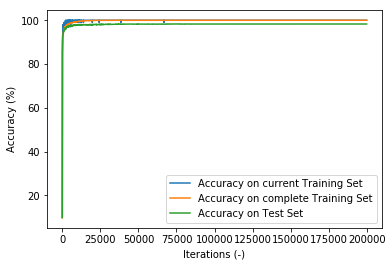

In [10]:
plt.plot( progress_iterations, progress_train_current, label = 'Accuracy on current Training Set' )

plt.plot( progress_iterations, progress_train, label = 'Accuracy on complete Training Set' )

plt.plot( progress_iterations, progress_test, label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

Text(0, 0.5, 'Accuracy (%)')

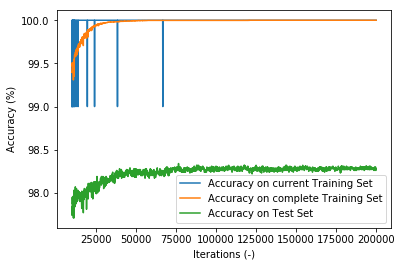

In [11]:
plt.plot( progress_iterations[ 100 : 2000 ], progress_train_current[ 100 : 2000 ], 
         label = 'Accuracy on current Training Set' )

plt.plot( progress_iterations[ 100 : 2000 ], progress_train[ 100 : 2000 ], label = 'Accuracy on complete Training Set' )

plt.plot( progress_iterations[ 100 : 2000 ], progress_test[ 100 : 2000 ], label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

Text(0, 0.5, 'Accuracy (%)')

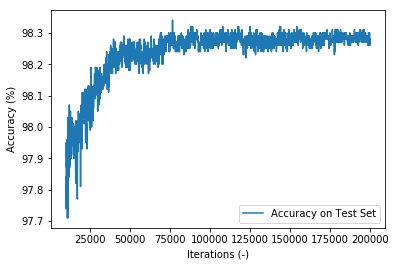

In [12]:
plt.plot( progress_iterations[ 100 : 2000 ], progress_test[ 100 : 2000 ], label= 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

In [13]:
saver = tf.train.Saver()

saver.save( sess, 
           "C:\\Users\\rhopi\\OneDrive\\Desktop\\python dev\\github\\lesson_0020\\convolutional_neural_network_128_128" )

sess.close()

At around iteration $75000$, the network has learnt all the training data, and therefore, all the updates on the weights are only random noise because these updates aim at improving the performance on the training set which cannot be improved once the training set is completely learnt.<br>
When we compare this model to the model from [lesson 0019](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0019_mnist_classification_convolutional_neural_network_2.ipynb) we notice, that this model performs slightly better than the model from [lesson 0019](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0019_mnist_classification_convolutional_neural_network_2.ipynb).<br>
Class dismissed.